In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from IPython.display import display
import astropy.units as u
from astropy.coordinates import EarthLocation
from pathlib import Path
from gammapy.catalog import SourceCatalog1LHAASO, CATALOG_REGISTRY
import numpy as np
from astropy.coordinates import SkyCoord
from gammapy.irf import load_irf_dict_from_file
from gammapy.data import FixedPointingInfo, Observation
from gammapy.maps import MapAxis, WcsGeom
from gammapy.datasets import MapDataset
from gammapy.modeling.models import (
    FoVBackgroundModel,
#    GaussianSpatialModel,
    Models,
#    PowerLawSpectralModel,
    SkyModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker

from scipy.optimize import curve_fit
import pickle
import time

In [3]:
# loading location ondrojev file
p = Path('../')
loc_ondrejov = p / 'config/location_ondrejov.txt'

with open(loc_ondrejov) as f:
    lat,lon,height = f.readline().split()

location_ondrejov = EarthLocation(
    lat = float(lat) * u.deg,
    lon = float(lon) * u.deg,
    height = float(height) * u.m)

print(f'Ondrejov location: {location_ondrejov}')

# Loading IRFs
irfs_dict = {}
for z in ['20','30','40']:
    irfs_dict[z] = p / f"IRFs/data/sst1m_stereo/0_4/bcf/ze{z}_az180_nsb100_gc0.75/SST1M_stereo_Zen{z}deg_gcut0.75_irfs.fits"

Ondrejov location: (3979453.55748948, 1050094.12597485, 4856894.19463016) m


## Create a list of pre-selected source, potentially visible above 40 deg elevation, according to SST1M sensitivity
### This pre-selection can be done running another notebook "xxx.ipynb'

In [4]:
catalog = CATALOG_REGISTRY.get_cls("1LHAASO")()

In [5]:
# Already filtered good sources: (above SST1M sensitivity) and (above 40deg elevation)
above_40 = ['1LHAASO J0007+7303u','1LHAASO J0534+2200u','1LHAASO J0634+1741u','1LHAASO J0703+1405','1LHAASO J1104+3810','1LHAASO J1653+3943','1LHAASO J1852+0050u*','1LHAASO J1908+0615u','1LHAASO J2018+3643u','1LHAASO J2020+3638','1LHAASO J1857+0245','1LHAASO J2229+5927u']
above_40_i = [1,13,18,20,21,23,43,44,50,74,76,86]

# FITS file is loaded
catalog = CATALOG_REGISTRY.get_cls("1LHAASO")()

catalog.table['N0'].format = '%.2e'
catalog.table['N0_err'].format = '%.2e'
catalog.table['N0_b'].format = '%.2e'
catalog.table['N0_err_b'].format = '%.2e'
catalog.table['N0_ul_b'].format = '%.2e'
catalog.table[above_40_i]['Source_Name','Model_a','RAJ2000','DECJ2000','pos_err','r39','r39_err','r39_ul','N0','N0_err','gamma','gamma_err','E0','TS','TS100','Model_b','RAJ2000_b','DECJ2000_b','pos_err_b','r39_b','r39_err_b','r39_ul_b','N0_b','N0_err_b','N0_ul_b','gamma_b','gamma_err_b','E0_b','TS_b','TS100_b','ASSO_Name','ASSO_Sep']

Source_Name,Model_a,RAJ2000,DECJ2000,pos_err,r39,r39_err,r39_ul,N0,N0_err,gamma,gamma_err,E0,TS,TS100,Model_b,RAJ2000_b,DECJ2000_b,pos_err_b,r39_b,r39_err_b,r39_ul_b,N0_b,N0_err_b,N0_ul_b,gamma_b,gamma_err_b,E0_b,TS_b,TS100_b,ASSO_Name,ASSO_Sep
,,deg,deg,deg,deg,deg,deg,1 / (TeV s cm2),1 / (TeV s cm2),,,TeV,,,,deg,deg,deg,deg,deg,deg,1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),,,TeV,,,,deg
bytes20,bytes7,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes16,float64
1LHAASO J0007+7303u,KM2A,1.91,73.07,0.07,0.17,0.03,--,3.41e-16,2.70e-17,3.4,0.12,50.0,361.0,171.6,WCDA,1.48,73.15,0.1,--,--,0.22,5.01e-13,1.11e-13,--,2.74,0.11,3.0,141.6,--,CTA 1,0.12
1LHAASO J0534+2200u,WCDA,83.62,22.01,0.004,--,--,0.04,2.11e-12,1.10e-14,2.69,0.01,3.0,73603.7,--,KM2A,83.61,22.04,0.011,--,--,0.06,6.23e-16,1.00e-17,--,3.19,0.03,50.0,14328.1,2381.4,Crab,0.01
1LHAASO J0634+1741u,KM2A,98.57,17.69,0.1,0.89,0.04,--,4.42e-16,1.50e-17,3.69,0.06,50.0,1043.3,23.0,WCDA,98.51,17.72,0.28,1.16,0.17,--,1.53e-13,6.50e-14,--,1.65,0.15,3.0,193.2,--,Geminga,0.54
1LHAASO J0703+1405,KM2A,105.83,14.1,0.26,1.88,0.09,--,6.30e-16,2.30e-17,3.98,0.08,50.0,841.0,--,WCDA,105.32,14.55,0.48,1.3,0.21,--,2.27e-13,7.40e-14,--,1.98,0.12,3.0,90.2,--,2HWC J0700+143,0.72
1LHAASO J1104+3810,WCDA,166.07,38.18,0.01,--,--,0.04,3.68e-13,1.00e-14,3.41,0.03,3.0,5343.6,--,KM2A,--,--,--,--,--,--,--,--,6.00e-18,--,--,50.0,--,--,Markarian 421,0.02
1LHAASO J1653+3943,WCDA,253.43,39.73,0.01,--,--,0.04,3.77e-13,8.00e-15,2.94,0.02,3.0,4121.6,--,KM2A,--,--,--,--,--,--,--,--,7.00e-18,--,--,50.0,--,--,Markarian 501,0.04
1LHAASO J1852+0050u*,KM2A*,283.1,0.84,0.26,0.85,0.06,--,3.22e-16,2.20e-17,3.64,0.12,50.0,275.6,22.1,WCDA,283.73,1.4,0.2,0.64,0.07,--,4.67e-13,7.00e-14,--,2.74,0.06,3.0,231.0,--,2HWC J1852+013*,0.55
1LHAASO J1857+0245,WCDA,284.37,2.75,0.11,0.24,0.04,--,4.04e-13,5.70e-14,2.93,0.07,3.0,361.0,--,KM2A,--,--,--,--,--,--,--,--,3.20e-17,--,--,50.0,--,--,HESS J1857+026,0.11


In [6]:
class Create_dataset():
    """Simulate a list of events based on instrumental IRF and pointing and source information
    
    Parameters
    ----------
    pointing_position : SkyCoord
        Where the telescope is pointing
    En : array
        Binning in energy for the simulation
    En_true : array
        Binning in reconstructed energy for the simulation
    source : SourceCatalog Class
    source_w : SkyModel `gammapy.modeling.models.cube.SkyModel`
    irfs : dict
        a dictionary containng the list of IRFs
    hour : float
        exposure of the simulation
    force_gamma : None or float
        If force_gamma is a number it overwrites the photon index of the model
    force_norm : None or float [TeV-1 s-1 cm-2] @ 3TeV en ref for WCDA or 50TeV for KM2A
        If force_norm is a number it overwrites the normalisation of the model
    pointlike : bool
        True if the source in the model is pointlike
    mask_region : `gammapy.region`
        Example of spatial region from `CircleSkyRegion`
        crop = CircleSkyRegion(center=self.source_w.spatial_model.position.icrs, radius=0.2*u.deg)

    Returns
    -------
    dataset : `gammapy.datasets.map.MapDataset`
        Map of the predicted signal counts.
    """
    
    def __init__(self,pointing_position,En,En_true,source,source_w,irfs,hour=20.0,force_gamma=None,force_norm=None,pointlike=True,source_k=None,mask_reg=None,offset_max=4,seed=None):
        self.fov = (9.0, 9.0)
        self.pointing_position = pointing_position
        self.En = En
        self.En_true = En_true
        self.source = source
        self.source_w = source_w
        if source_k:
            self.source_k = source_k
            self.spatial_model_k  = self.source_k.spatial_model
            self.spectral_model_k = self.source_k.spectral_model
        self.irfs = irfs
        self.hour = hour
        self.pointlike = pointlike
        self.spatial_model  = self.source_w.spatial_model
        self.spectral_model = self.source_w.spectral_model
        self.mask_reg = mask_reg
        self.offset_max = offset_max
        self.seed = seed

        if self.pointlike:
            if force_gamma:
                self.source_w.spectral_model.index.value = force_gamma
            if force_norm:
                self.source_w.spectral_model.amplitude.value = force_norm                
            self.gamma = self.source_w.spectral_model.index.value
            self.norm = self.source_w.spectral_model.amplitude.value
        
        # Main
        self.prepare_models()
        self.prepare_makers()
        self.simulate()
        
    def prepare_models(self):
        # Define the observation parameters (typically the observation duration and the pointing position):
        self.livetime = self.hour * u.hr
        # We want to simulate an observation pointing at a fixed position in the sky: `FixedPointingInfo`
        self.pointing = FixedPointingInfo(fixed_icrs=self.pointing_position.icrs,)
    
        # Define map geometry for binned simulation
        self.energy_reco = MapAxis.from_edges(self.En, unit="TeV", name="energy", interp="log")
        geom = WcsGeom.create(
            skydir=(self.pointing_position.icrs),
            binsz=0.01,
            width=(9.0, 9.0),
            frame="icrs",
            axes=[self.energy_reco],
        )
        self.geom = geom
        # It is usually useful to have a separate binning for the true energy axis
        self.energy_true = MapAxis.from_edges(self.En_true, unit="TeV", name="energy_true", interp="log")
    
        self.empty = MapDataset.create(geom, name="dataset-simu", energy_axis_true=self.energy_true)
        
        model_simu = SkyModel(
            spatial_model=self.spatial_model,
            spectral_model=self.spectral_model,
            name="model-simu",
        )
    
        bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")

        bkg_model.spectral_model.norm.value = 1
        
        self.models = Models([model_simu, bkg_model])
    
        # Create an in-memory observation
        location = location_ondrejov
        self.obs = Observation.create(
            pointing=self.pointing, livetime=self.livetime, irfs=self.irfs, location=location
        )

    def prepare_makers(self):
        # Make the MapDataset
        maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
    
        maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=self.offset_max * u.deg)
    
        dataset = maker.run(self.empty, self.obs)
    
        self.dataset = maker_safe_mask.run(dataset, self.obs)

    def simulate(self):
        if self.mask_reg != None:
            reg_mask = self.dataset.counts.geom.region_mask(self.mask_reg)
            self.dataset.mask_fit = reg_mask
        # Add the model on the dataset and Poisson fluctuate
        self.dataset.models = self.models
        if self.seed is not None:
            self.dataset.fake(self.seed)
        else:
            self.dataset.fake()

In [7]:
# Defining parameters
En = np.logspace(0.3, 1.4, 10) # 2 TeV - 25 TeV
En_true = np.logspace(0, 2, 20)

# We select a random not pointlike source, and we will change later on the extension

In [8]:
source_name_catalogue = '1LHAASO J2229+5927u'
source_name_file = source_name_catalogue.replace(' ','_')
source_name_file = source_name_file.replace('*','x')

# Study TS vs. Time

In [7]:
def model_func(x, a, b):
        return a * np.sqrt(x) + b
    
def plot_ts_vs_rad_and_time(ext, source_w, z, exposure, src_t, save_plot=False, seed=None):
    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
    fig.suptitle(f'Pointlike: ext={ext:.2f}deg, norm={source_w.spectral_model.amplitude.value:.2e}, gamma={source_w.spectral_model.index.value:.2e}')
    ax1.set_title('TS (cash) statistic vs. Rad dist (for different Exposure')
    ax1.set_xlabel('Radial distance [deg]')
    ax1.set_ylabel('sqrt(TS) Cash statistic [sigma]')
    
    sigma_max = []
    for t in exposure: 
        pl = ax1.plot(src_t['radius'],src_t[t]['sqrt_ts'],'x-',label=f'{t} hours')
        ax1.axvline(src_t['radius'][np.argmax(src_t[t]['sqrt_ts'])], c=pl[0].get_color(), ls='--')
        sigma_max.append(max(src_t[t]['sqrt_ts']))
    ax1.legend(loc=1)
    
    ax1.set_title('TS (cash) statistic vs. Exposure Time')
    ax2.set_xlabel('Exposure Time [hours]')
    ax2.set_ylabel('sqrt(TS) Cash statistic [sigma]')
    
    ts_within_01_deg,ts_within_02_deg,ts_within_03_deg,ts_within_04_deg = [],[],[],[]
    for t in exposure:
        ts_within_01_deg.append(src_t[t]['sqrt_ts'][5])
        ts_within_02_deg.append(src_t[t]['sqrt_ts'][10])
        ts_within_03_deg.append(src_t[t]['sqrt_ts'][15])
        ts_within_04_deg.append(src_t[t]['sqrt_ts'][20])
    ax2.plot(exposure,sigma_max,label='max_TS')
    ax2.plot(exposure,ts_within_01_deg,label='within 0.1 deg')
    ax2.plot(exposure,ts_within_02_deg,label='within 0.2 deg')
    ax2.plot(exposure,ts_within_03_deg,label='within 0.3 deg')
    ax2.plot(exposure,ts_within_04_deg,label='within 0.4 deg')
    
    params, params_covariance_matrix = curve_fit(model_func, exposure, sigma_max)
    x = np.arange(0,50,0.5)
    ax2.plot(x, model_func(np.arange(0,50,0.5), *params), label='sqrt fit', ls='--', c='k')
    ax2.legend()

    if save_plot:
        if seed is not None:
            figname = p / f'debug/z{z}/ext/norm_{source_w.spectral_model.amplitude.value:.2e}_gamma_{source_w.spectral_model.index.value:.2e}_ext_{ext:.2f}deg_seed_{seed:03d}.png'
        else:
            figname = p / f'debug/z{z}/ext/norm_{source_w.spectral_model.amplitude.value:.2e}_gamma_{source_w.spectral_model.index.value:.2e}_ext_{ext:.2f}deg.png'
        # Check folder existence, otherwise create them
        path = ''
        for fold in ['../debug',f'/z{z}','/ext']:
            path += fold
            Path(path).mkdir(exist_ok=True)

        fig.savefig(figname)

In [84]:
plt.ioff()
tstart = time.time()
# Simplify (lighter) the data output
source_name_catalogue = '1LHAASO J2229+5927u'
source_name_file = source_name_catalogue.replace(' ','_')
source_name_file = source_name_catalogue.replace('*','x')

source = catalog[source_name_catalogue]
source_w = source.sky_model(which='WCDA')
source_k = source.sky_model(which='KM2A')
offset_deg = 1.4*u.deg
pointing_position = SkyCoord(source_w.spatial_model.position.icrs.directional_offset_by(0,offset_deg), unit="deg", frame="icrs")
z = '20' # '20', '30', '40'
irfs = load_irf_dict_from_file(irfs_dict[z]) # choose between IRF20, IRF30, IRF40

seeds = np.arange(0,10,1)
radius = np.arange(0.0,5.01,0.02)
exposure = np.array([1, 10, 50])

for ext in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]:
    print(f'--> Extension : {ext} deg')
    for seed in seeds:
        print(f'Seed = {seed:03d}')
        src_t = {}
        src_t['radius'] = radius
        # Force extension
        source_w.spatial_model.sigma.value = ext
        for t in exposure: # hours
            print(f'Time = {t} hours')
            src_t[t] = {}
            # Simulate source
            d = Create_dataset(pointing_position,En,En_true,source,source_w,irfs,hour=t,offset_max=4,seed=seed)#,force_norm=1e-10)
            # if you want to change also the normalization, do another proper loop and use the option 'force_norm' with the desired value
            #d = Create_dataset(pointing_position,En,En_true,source,source_w,irfs,hour=t,offset_max=4,seed=seed,force_norm=1e-10)
            n_sig = []
            sqrt_ts = []            
            for r in src_t['radius']:
                if r < 0.01:
                    n_sig.append(0)
                    sqrt_ts.append(0)
                else:
                    regions = f"icrs;box({source_w.spatial_model.position.icrs.ra.deg}, {source_w.spatial_model.position.icrs.dec.deg}, {r}, {r})"
                    mask = d.dataset.counts.geom.region_mask(regions)
                    summed_stat = d.dataset._counts_statistic[mask.data].sum()
                    n_sig.append(summed_stat.n_sig)
                    sqrt_ts.append(summed_stat.sqrt_ts)
            src_t[t]['n_sig'] = n_sig
            src_t[t]['sqrt_ts'] = sqrt_ts
            
        # Plot if you want to debug
        #plot_ts_vs_rad_and_time(ext, source_w, z, exposure, src_t, save=True, seed=seed)
        
        if (seed is not None):
            outname = f'../data/z{z}/z{z}_ext_{ext:.2f}deg_seed_{seed:03d}.pkl'
        else:
            outname = f'../data/z{z}/z{z}_ext_{ext:.2f}deg.pkl'

        # Check folder existence, otherwise create them
        path = ''
        for fold in ['../data',f'/z{z}']:
            path += fold
            Path(path).mkdir(exist_ok=True)
            
        with open(outname, 'wb') as f:
            pickle.dump(src_t, f)
        tstop = time.time()
        dt = tstop - tstart
        print(f"Elapsed time: {dt:.1f} sec = {dt/60:.2f} min = {dt/3600:.4f} hour")

Seed = 000
Time = 1 hours
Time = 10 hours
Time = 50 hours
Elapsed time: 68.1 sec = 1.13 min = 0.0189 hour
Seed = 001
Time = 1 hours
Time = 10 hours
Time = 50 hours
Elapsed time: 136.0 sec = 2.27 min = 0.0378 hour
Seed = 002
Time = 1 hours
Time = 10 hours
Time = 50 hours
Elapsed time: 203.1 sec = 3.39 min = 0.0564 hour
Seed = 003
Time = 1 hours
Time = 10 hours
Time = 50 hours
Elapsed time: 269.3 sec = 4.49 min = 0.0748 hour
Seed = 004
Time = 1 hours
Time = 10 hours
Time = 50 hours
Elapsed time: 340.7 sec = 5.68 min = 0.0946 hour
Seed = 005
Time = 1 hours
Time = 10 hours
Time = 50 hours
Elapsed time: 413.0 sec = 6.88 min = 0.1147 hour
Seed = 006
Time = 1 hours
Time = 10 hours
Time = 50 hours
Elapsed time: 486.0 sec = 8.10 min = 0.1350 hour
Seed = 007
Time = 1 hours
Time = 10 hours
Time = 50 hours
Elapsed time: 557.2 sec = 9.29 min = 0.1548 hour
Seed = 008
Time = 1 hours
Time = 10 hours
Time = 50 hours
Elapsed time: 627.3 sec = 10.45 min = 0.1742 hour
Seed = 009
Time = 1 hours
Time = 10 h

KeyboardInterrupt: 

## If you want to read the file use:

In [45]:
pkl = {}
for seed in range(10):
    outname = f'../data/z{z}/z{z}_ext_{ext:.2f}deg_sed_{seed:03d}.pkl'
    file = open(outname, 'rb')
    data = pickle.load(file)
    pkl[f'{seed:03d}'] = data

# DEBUG: Check TS evolution vs. time and standard deviation with larger statistic

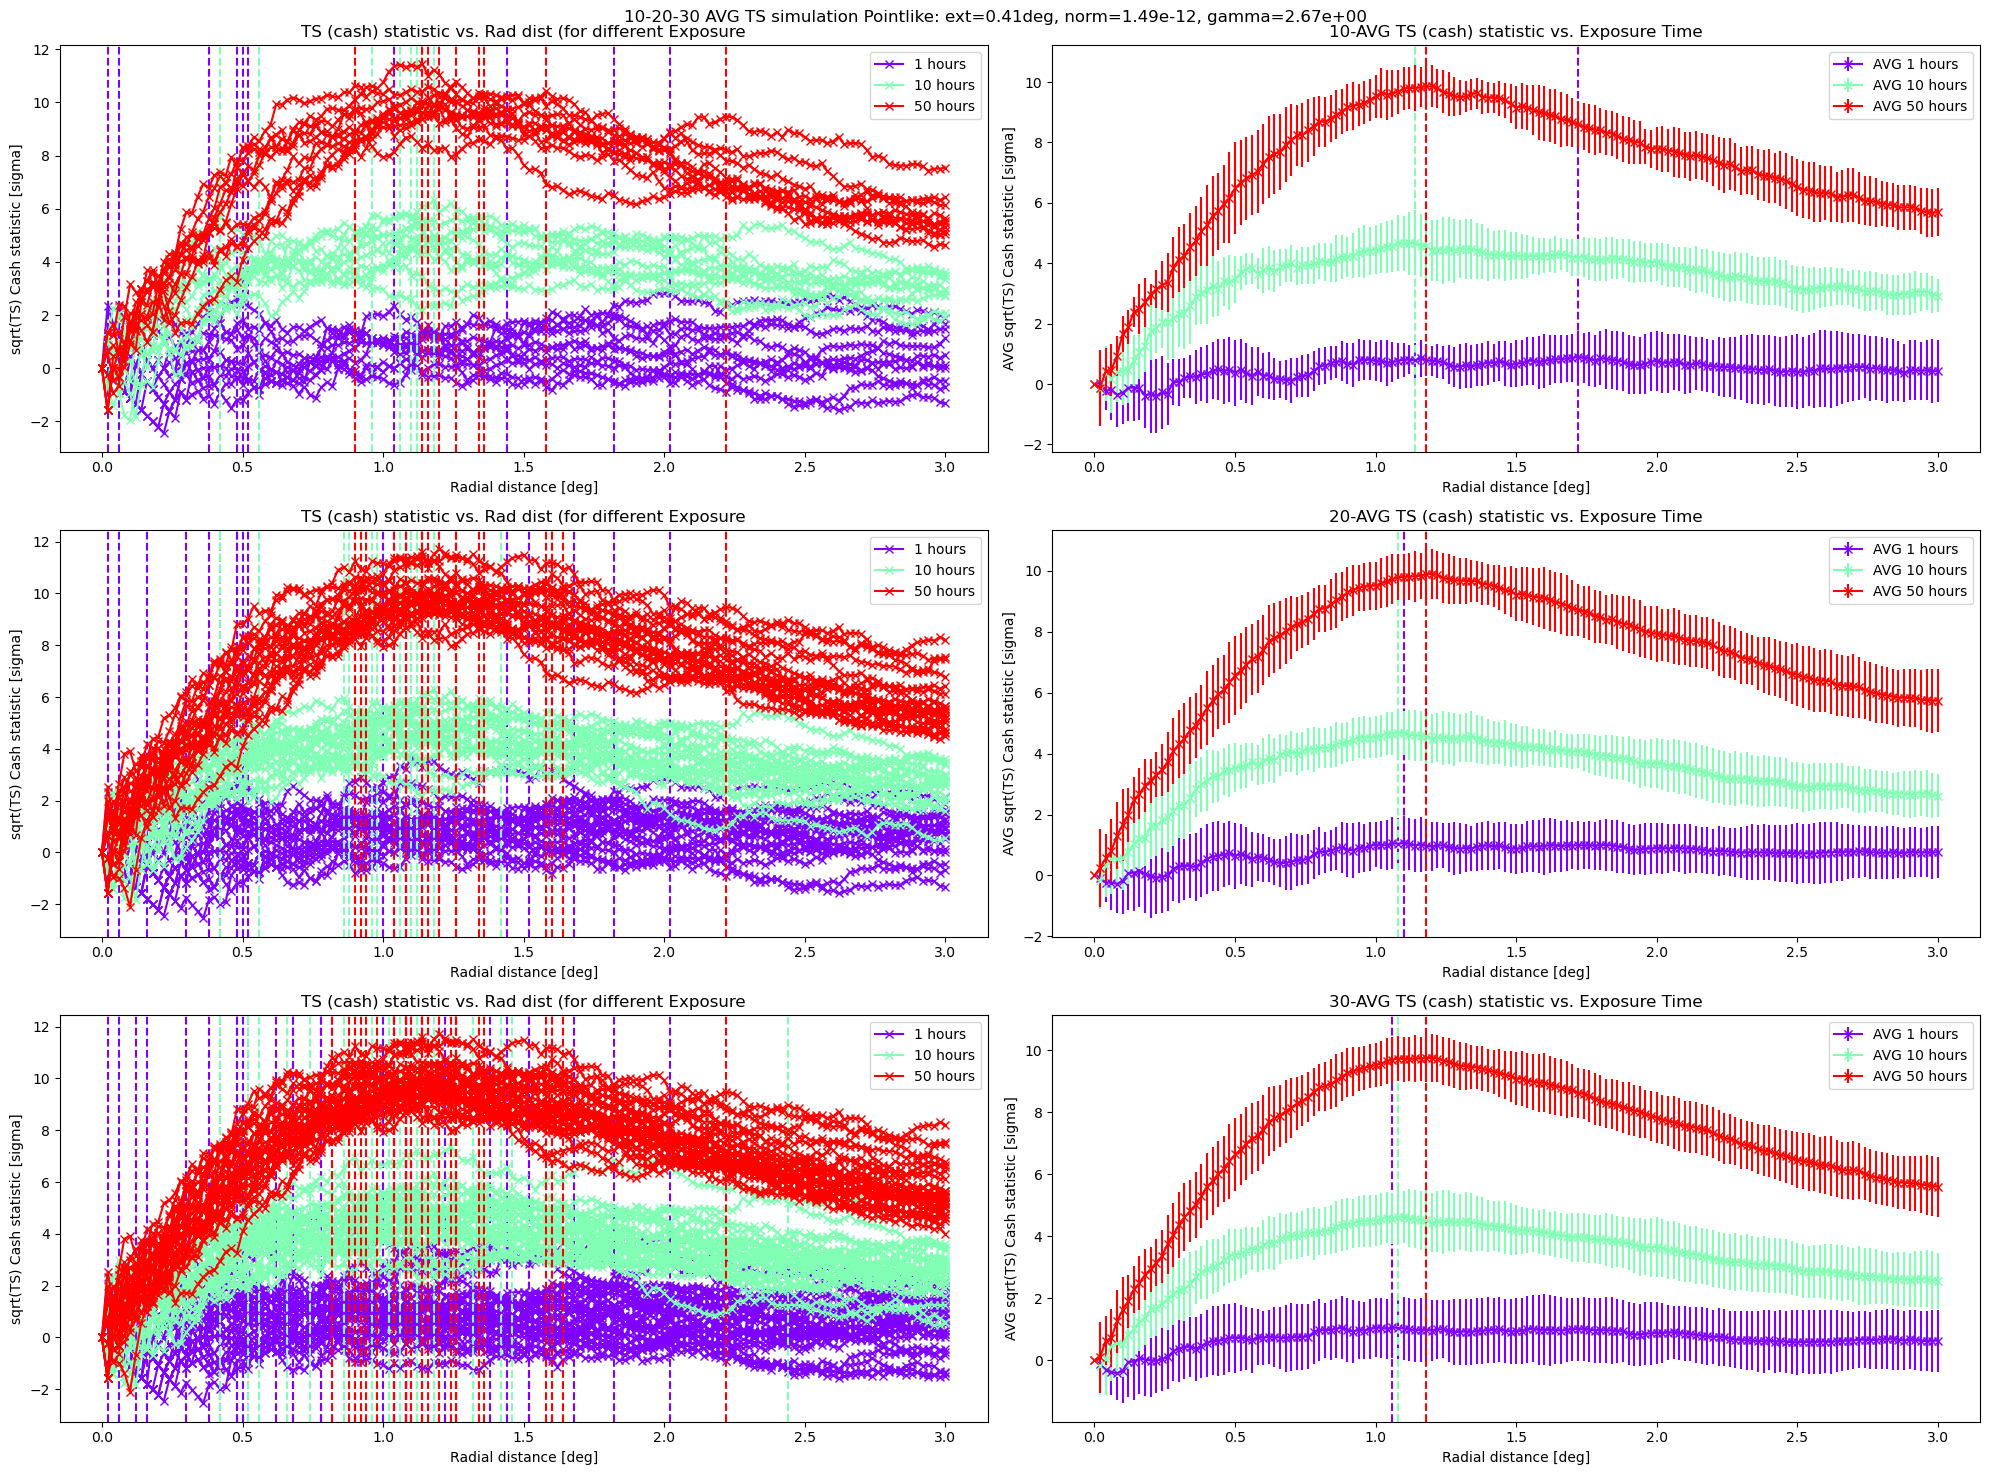

In [82]:
save_plot = True
seeds = np.arange(0,30,1)
fig, ((ax1, ax2),(ax3, ax4),(ax5, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(20, 15))
fig.suptitle(f'10-20-30 AVG TS simulation Pointlike: ext={ext:.2f}deg, norm={source_w.spectral_model.amplitude.value:.2e}, gamma={source_w.spectral_model.index.value:.2e}')

exposure = np.array([1, 10, 50])
radius = np.arange(0.0,3.01,0.02)

for a,b,c in zip((ax1,ax3,ax5),(ax2,ax4,ax6),(10,20,30)):
    std_deviation_per_line = {}
    a.set_title('TS (cash) statistic vs. Rad dist (for different Exposure')
    b.set_title(f'{c}-AVG TS (cash) statistic vs. Exposure Time')
    a.set_xlabel('Radial distance [deg]')
    a.set_ylabel('sqrt(TS) Cash statistic [sigma]')
    b.set_xlabel('Radial distance [deg]')
    b.set_ylabel('AVG sqrt(TS) Cash statistic [sigma]')
    color = iter(cm.rainbow(np.linspace(0, 1, num=len(exposure))))
    for t in exposure:
        col = next(color)
        first = True
        ts_arr = np.zeros_like(radius)
        for seed in seeds[:c]:
            prefix = '' if first else '_'
            src_t = pkl[f'{seed:03d}']
            pl = a.plot(src_t['radius'],src_t[t]['sqrt_ts'],'x-',label=f'{prefix}{t} hours',c=col)
            a.axvline(src_t['radius'][np.argmax(src_t[t]['sqrt_ts'])], c=pl[0].get_color(), ls='--')
            ts_arr += src_t[t]['sqrt_ts']
            first = False
        ts_arr /= len(seeds[:c])
        test = []
        for seed in seeds[:c]:
            test.append(pkl[f'{seed:03d}'][t]['sqrt_ts'])
        stacked_array = np.stack(test)
        std_deviation_per_line[t] = np.std(stacked_array, axis=0)
        pl = b.errorbar(src_t['radius'],ts_arr,yerr=std_deviation_per_line[t],marker='x',ls='-',label=f'AVG {t} hours',c=col)
        b.axvline(src_t['radius'][np.argmax(ts_arr)], c=pl[0].get_color(), ls='--')
    b.legend()
    a.legend(loc=1)
    
fig.tight_layout()
if save_plot:
    #if seed is not None:
    #    figname = p / f'debug/z{z}/ext/norm_{source_w.spectral_model.amplitude.value:.2e}_gamma_{source_w.spectral_model.index.value:.2e}_ext_{ext:.2f}deg_seed_{seed:03d}.pdf'
    #else:
    #    figname = p / f'debug/z{z}/ext/norm_{source_w.spectral_model.amplitude.value:.2e}_gamma_{source_w.spectral_model.index.value:.2e}_ext_{ext:.2f}deg.pdf'
    figname = p / f'debug/z{z}/ext/norm_{source_w.spectral_model.amplitude.value:.2e}_gamma_{source_w.spectral_model.index.value:.2e}_ext_{ext:.2f}deg_AVG.pdf'
    fig.savefig(figname)

# Study which is the more time-expensive process

In [18]:
#%prun light_proc()

--> Extension : 0.001 deg
Time = 1 hours
Time = 10 hours
Time = 50 hours


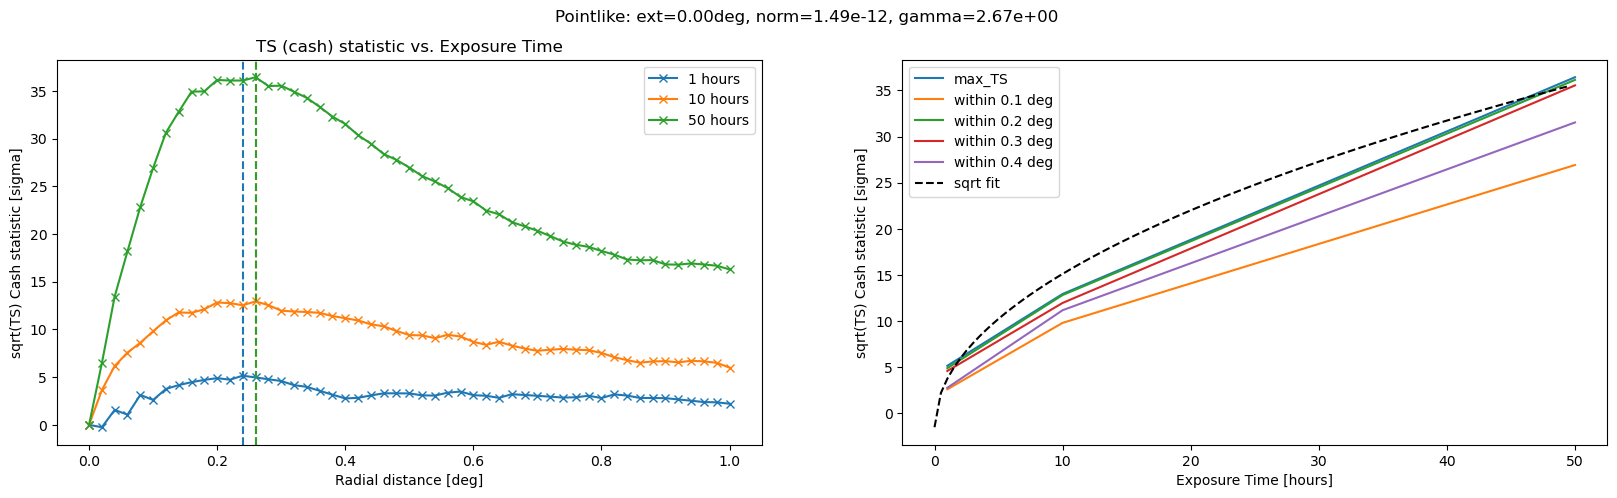

Timer unit: 1e-09 s

Total time: 29.5809 s
File: /var/folders/80/sdvy46fd1zx4qv2r0xs9c3t40000gn/T/ipykernel_66953/3800852025.py
Function: light_proc at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def light_proc():
     2                                               # Simplify (lighter) the data output
     3         1       2000.0   2000.0      0.0      source_name_catalogue = '1LHAASO J2229+5927u'
     4         1       2000.0   2000.0      0.0      source_name_file = source_name_catalogue.replace(' ','_')
     5         1       1000.0   1000.0      0.0      source_name_file = source_name_catalogue.replace('*','x')
     6                                               
     7         1    3485000.0    3e+06      0.0      source = catalog[source_name_catalogue]
     8         1   21894000.0    2e+07      0.1      source_w = source.sky_model(which='WCDA')
     9         1   14070000.0    1e+07      0.0      sour

In [19]:
#%load_ext line_profiler
#%lprun -f light_proc light_proc()